# Order Cancellations on Amazon: Data Visualization, Statistical Analysis and Prediction 

Dataset - https://www.kaggle.com/datasets/zahidmughal2343/amazon-sales-2025

# Introduction 
Cancelled orders represent a significant challenge for e-commerce platforms like Amazon, affecting revenue, logistics, and customer satisfaction. This project explores a Kaggle dataset of Amazon orders to analyse predictors of order cancellations. Although this project uses a small dataset, it provides practical, business-relevant signals drawn from common fields such as product details, payment method, location, and order amounts. We treat the findings as directional due to the dataset’s modest size. 

This project analyses: 
- How many products were cancelled overall
- Sales lost from cancelled orders 
- Cancelled products in each category of products
- For all the products that were cancelled, what payment methods were used? (pie chart)
- Were expensive products cancelled more often?
For each of the potential predictors, Chi-square tests were conducted for each categorical variable, such as product category, payment method, and price of the product to find out if there exists any statistical significance.

Additionally, this project uses a simple logistic-regression model that **flags ~93% of cancelled orders** while tolerating more false positives (meaning fewer false negatives), so operations can intervene early and manage potential cancellations well in advance 

# Abstract 
Using a Kaggle Amazon Sales Dataset, this project analyzes predictors of cancellation and flags high-recall cancellations. Exploratory Data Analysis summarizes how many products were cancelled, sales lost due to cancellation, cancellations by category, payment methods used for cancelled orders, and whether price influenced order cancellation. To explore patterns beyond visualisation, I ran chi-square tests on categorical predictors (product category and payment method) and correlation for numeric fields. There was no statistical correlation between price and order cancellation, nor was there any statistically significant association between product type and order cancellation. However, there seems to be a statistically significant association between payment method and order cancellations, meaning cancellations are not evenly distributed across payment types. Gift Cards and Debit Card payments show higher cancellation rates, while Amazon Pay has the lowest. Payment method appears to influence whether an order is completed or cancelled. 

For prediction, I frame cancellation as a binary classification task and build an intro-level scikit-learn pipeline (median/mode imputation and one-hot encoding via a ColumnTransformer; stratified 80:20 test: train split; Logistic Regression with balanced class weights). On the held-out test set (n=50), the default 0.50 threshold yields Accuracy 0.58, Precision 0.33, Recall 0.40, and F1 0.36. Tuning the decision threshold to 0.25 prioritizes recall—Recall 0.93, Precision 0.37, F1 0.53, Accuracy 0.50—intentionally tolerating more false positives so operations can manage potential cancellations earlier. Given the modest sample size, results are directional and reported with appropriate caution.

In [45]:
#libraries used  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Products cancelled overall 

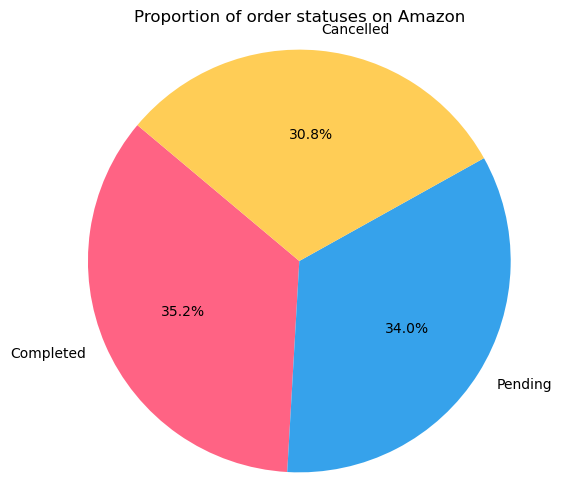

In [46]:
#number of orders by status 
status_counts = df['Status'].value_counts()

#Plotting 
plt.figure(figsize=(6,6))
plt.pie(status_counts, 
       labels=status_counts.index,
        autopct='%1.1f%%',
       startangle=140, 
       colors=['#ff6384', '#36a2eb', '#ffcd56'])
plt.title('Proportion of order statuses on Amazon')
plt.axis('equal')
plt.show()


# Loss of sales due to cancelled orders 

In [47]:
# new dataframe containing only cancelled orders 
cancelled = df[df['Status'] == 'Cancelled'].copy()
# new column containing lost sales by quantity * price of cancelled orders 
cancelled['LostSales'] = cancelled['Quantity'] * cancelled['Price']
# sum of lost sales column 
total_lost_sales = cancelled['LostSales'].sum()

print(f"Total Sales Lost Due to Cancelled Orders: ${total_lost_sales}")


Total Sales Lost Due to Cancelled Orders: $65030


# Cancelled Patterns in Product Categories 

## Visualisation 

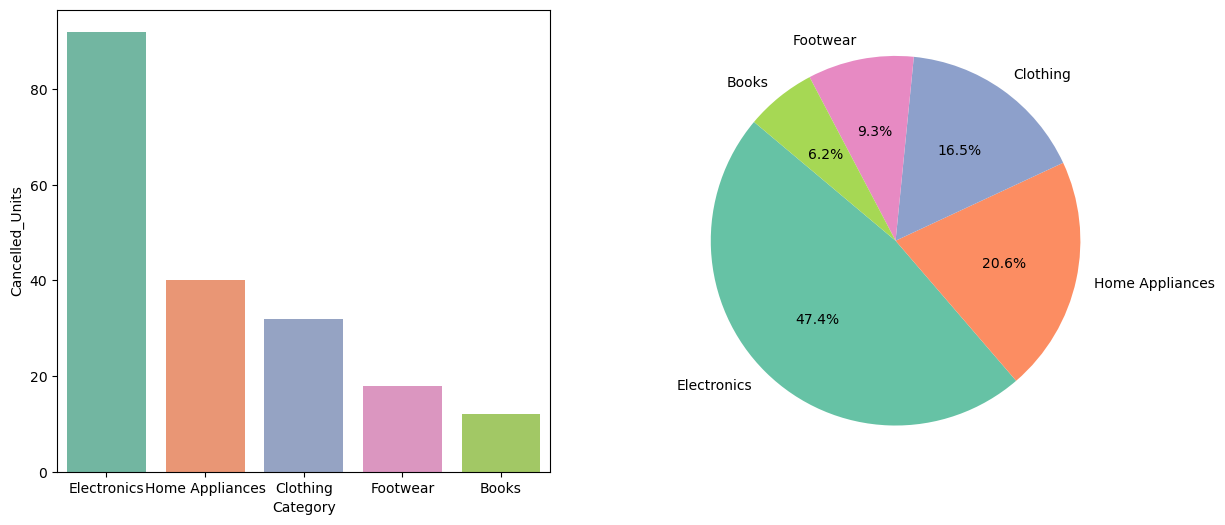

In [48]:
#new dataframe with cancelled orders  
cancelled = df[df['Status'] == 'Cancelled']
# sorting categories 
group = cancelled.groupby('Category')['Quantity'].sum()

# Rename columns
cancelled_by_units = (
    cancelled.groupby('Category', as_index=False)['Quantity']
             .sum()
             .rename(columns={'Quantity': 'Cancelled_Units'})
             .sort_values('Cancelled_Units', ascending=False)
)


#side by side plots 
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Bar chart
sns.barplot(
    data=cancelled_by_units,
    x='Category',
    y='Cancelled_Units',
    hue='Category',
    palette='Set2',
    legend=False,
    ax=axes[0]
)

# Pie chart 
_ = axes[1].pie(
    cancelled_by_units['Cancelled_Units'],
    labels=cancelled_by_units['Category'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Set2', n_colors=len(cancelled_by_units))
)


## Statistical analysis for association  

Null Hypothesis (H₀): There is no association between product category and order cancellation 
Alternative Hypothesis (Hₐ: There is an association between product category and order cancellation 

In [49]:
# creating a contingency table 
table = pd.crosstab(df['Category'],df['Status'])
#significance level  
alpha = 0.05 
# chi^2 test to give test statistic, p-value and degree of freedom 
chi2, p, dof, expected = chi2_contingency(table)
#results 
print(table.to_string())
print (" ")
print(f"Test Statistic(Chi ^2) = {chi2}")
print(f"Degrees of Freedom = {dof}")
print(f"p-value = {p}")
print (" ")
# interpretation 
if p < alpha: 
    print ("Reject the null hypothesis, there is enough evidence to support the alternative hypothesis. There is a statistically significant association between product category and order cancellation")
else: 
    print("Fail to reject the null hypothesis, there isn't enough evidence to support the alternative hypothesis. There is no statistical significance association between product category and order cancellation")

Status           Cancelled  Completed  Pending
Category                                      
Books                    7          6       12
Clothing                13         15       12
Electronics             33         44       41
Footwear                 8         10        9
Home Appliances         16         13       11
 
Test Statistic(Chi ^2) = 4.875298437299933
Degrees of Freedom = 8
p-value = 0.7708175082799844
 
Fail to reject the null hypothesis, there isn't enough evidence to support the alternative hypothesis. There is no statistical significance association between product category and order cancellation


###### Based on the observed data, there is no statistically significant association between product type and order cancellation. This suggests that cancellations are not strongly influenced by product category alone, and other factors may have a more significant role in predicting whether an order gets cancelled. 

# Payment Method and order cancellation 

## Visualisation 

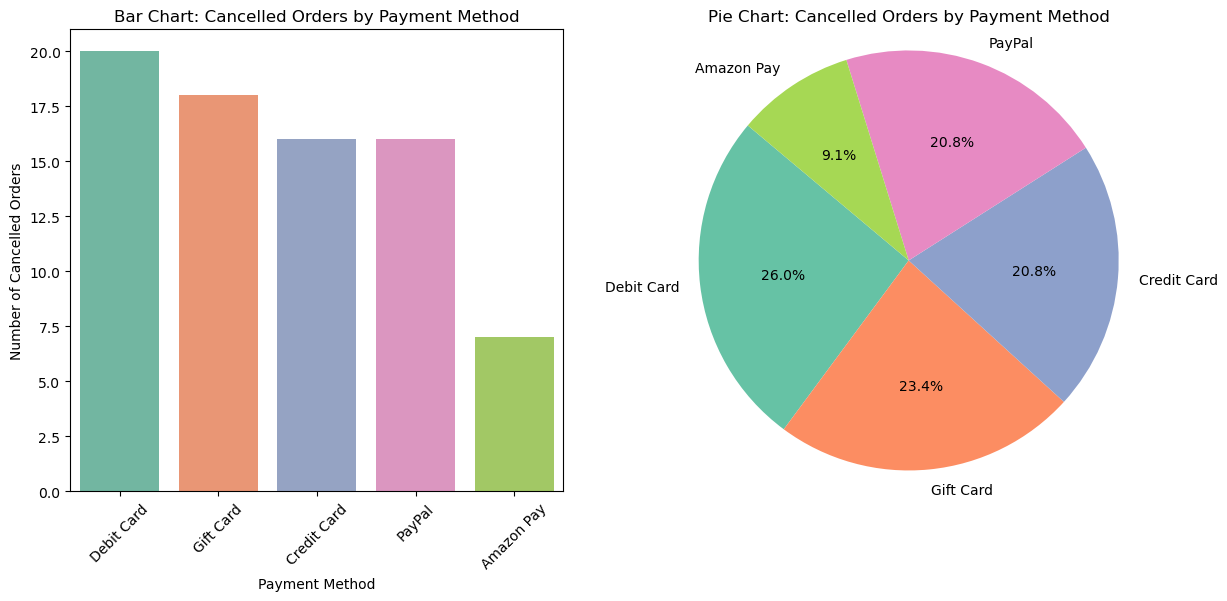

In [50]:
#filtering cancelled orders 
df['Status_Clean'] = df['Status'].str.strip().str.lower()
cancelled = df[df['Status_Clean'] == 'cancelled'].copy()

# number of payment methods used in cancellation 
payment_counts = cancelled['Payment Method'].value_counts().reset_index()
payment_counts.columns = ['Payment Method', 'Cancelled Orders']

#side by side plots 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# BAr chart 
sns.barplot(
    data=payment_counts,
    x='Payment Method',
    y='Cancelled Orders',
    hue = 'Payment Method',
    palette='Set2',
    ax=axes[0]
)
axes[0].set_title('Bar Chart: Cancelled Orders by Payment Method')
axes[0].set_xlabel('Payment Method')
axes[0].set_ylabel('Number of Cancelled Orders')
axes[0].tick_params(axis='x', rotation=45)

#Pie chart 
axes[1].pie(
    payment_counts['Cancelled Orders'],
    labels=payment_counts['Payment Method'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Set2', n_colors=len(payment_counts))
)
axes[1].set_title('Pie Chart: Cancelled Orders by Payment Method')
axes[1].axis('equal')
plt.show()

## Statistical Analysis 

Null Hypothesis (H₀): There is no association between the payment method used and the order being cancelled. 
Alternative Hypothesis (Hₐ): There is an association between the payment method used and the order being called. 

In [51]:
#needed columns 
df['Status_Clean'] = df['Status'].str.strip().str.lower()
df['Payment_Method_Clean'] = df['Payment Method'].str.strip()

#contingency table
contingency = pd.crosstab(df['Payment_Method_Clean'], df['Status_Clean'])

alpha = 0.05

#Chi^2 test 
chi2, p, dof, expected = chi2_contingency(contingency)

#results 
print(contingency.to_string())
print (" ")
print(f"Test Statistic(Chi ^2) = {chi2}")
print(f"Degrees of Freedom = {dof}")
print(f"p-value = {p}")
print (" ")

# interpretation 
if p < alpha: 
    print ("Reject the null hypothesis, there is enough evidence to support the alternative hypothesis. There is a statistically significant association between product category and order cancellation")
else: 
    print("Fail to reject the null hypothesis, there isn't enough evidence to support the alternative hypothesis. There is no statistical significance association between product category and order cancellation")


Status_Clean          cancelled  completed  pending
Payment_Method_Clean                               
Amazon Pay                    7         21       13
Credit Card                  16         17       21
Debit Card                   20         14       19
Gift Card                    18          6       18
PayPal                       16         30       14
 
Test Statistic(Chi ^2) = 22.464409137987566
Degrees of Freedom = 8
p-value = 0.004124439089185207
 
Reject the null hypothesis, there is enough evidence to support the alternative hypothesis. There is a statistically significant association between product category and order cancellation


###### This indicates a statistically significant association between payment method and order status, meaning cancellations are not evenly distributed across payment types. Gift Cards and Debit Card payments show higher cancellation rates, while Amazon Pay has the lowest. Payment method appears to influence whether an order is completed or cancelled. 

# Price-related Trends in Product Cancellation 

## Visualisation and Statistical analysis 

Pearson r = -0.06983520693297017
Coefficient of determination (r²) = 0.004876956127370765


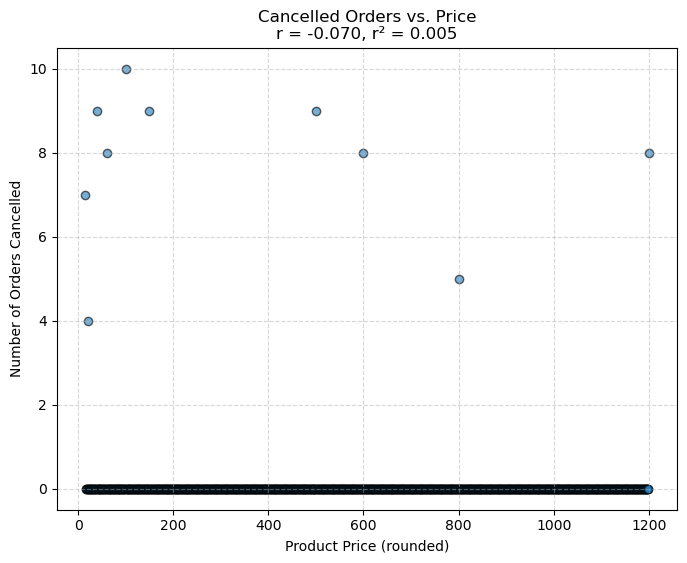

In [52]:
cancelled = df[df['Status'].str.lower() == 'cancelled'].copy()

#round prices to the nearest integer 
cancelled['Rounded Price'] = cancelled['Price'].round().astype(int)

#minimum and maximum price 
min_price = cancelled['Rounded Price'].min()
max_price = cancelled['Rounded Price'].max()

#list of the number of orders cancelled for each price 
prices = list(range(min_price, max_price + 1))
counts = [
    cancelled[cancelled['Rounded Price'] == p].shape[0]
    for p in prices
]

# storing the data in a dataframe 
group_df = pd.DataFrame({
    'Price': prices,
    'Cancelled Orders': counts
})

# computing r and r^2
r, _ = pearsonr(group_df['Price'], group_df['Cancelled Orders'])
r_squared = r ** 2
print(f"Pearson r = {r}")
print(f"Coefficient of determination (r²) = {r_squared}")

#plotting 
plt.figure(figsize=(8, 6))
plt.scatter(
    group_df['Price'],
    group_df['Cancelled Orders'],
    alpha=0.6,
    edgecolor='k'
)
plt.title(f"Cancelled Orders vs. Price\nr = {r:.3f}, r² = {r_squared:.3f}")
plt.xlabel("Product Price (rounded)")
plt.ylabel("Number of Orders Cancelled")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


The plot, r value, and r^2 value show that there is no significant correlation between the price of the product and it being cancelled. 

In [53]:
df.head()

,Order ID,Date,Product,Category,Price,Quantity,Total Sales,Customer Name,Customer Location,Payment Method,Status,Status_Clean,Payment_Method_Clean,Cancelled
0,ORD0001,14-03-25,Running Shoes,Footwear,60,3,180,Emma Clark,New York,Debit Card,Cancelled,cancelled,Debit Card,1
1,ORD0002,20-03-25,Headphones,Electronics,100,4,400,Emily Johnson,San Francisco,Debit Card,Pending,pending,Debit Card,0
2,ORD0003,15-02-25,Running Shoes,Footwear,60,2,120,John Doe,Denver,Amazon Pay,Cancelled,cancelled,Amazon Pay,1
3,ORD0004,19-02-25,Running Shoes,Footwear,60,3,180,Olivia Wilson,Dallas,Credit Card,Pending,pending,Credit Card,0
4,ORD0005,10-03-25,Smartwatch,Electronics,150,3,450,Emma Clark,New York,Debit Card,Pending,pending,Debit Card,0


# Predicting Cancelled Orders

In [55]:
# defining target: Cancelled = 1, Completed/Pending = 0 
df["Cancelled"] = (
    df["Status"].astype(str).str.strip().str.lower().eq("cancelled").astype(int)
)
# Dropping Order ID, Customer Name, Status, and Date 
X = df.drop(columns=["Order ID", "Customer Name", "Status", "Date", "Cancelled", "Status_Clean"], errors="ignore")
y = df["Cancelled"]


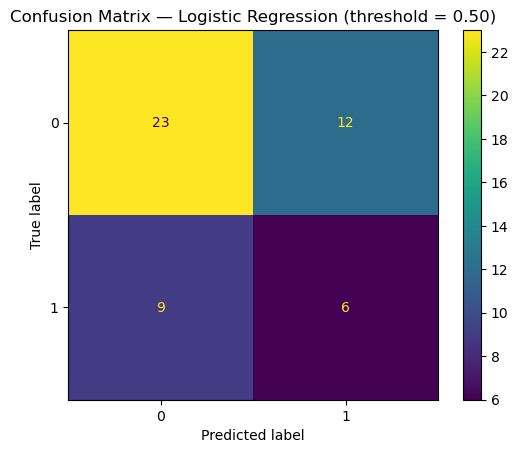

In [56]:
# Splittling- 80:20 train:test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
) 
# Preprocessing
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric, num_cols),
    ("cat", categorical, cat_cols)
])
# LogisticRegression Model 
logreg = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
logreg.fit(X_train, y_train)

# 0.5 threshold 
y_proba = logreg.predict_proba(X_test)[:, 1]
y_pred_050 = (y_proba >= 0.50).astype(int)

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_050)
plt.title("Confusion Matrix — Logistic Regression (threshold = 0.50)")
plt.show()


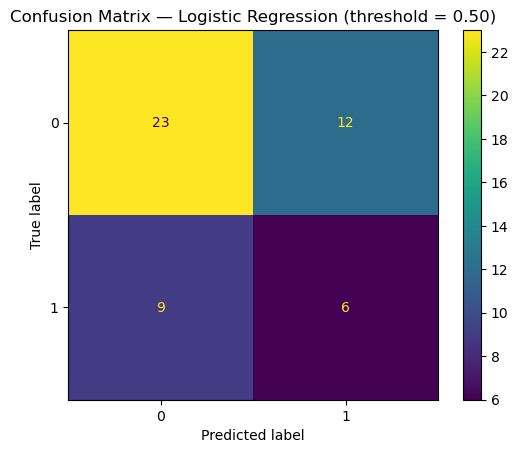

TN=23, FP=12, FN=9, TP=6
Accuracy: 0.58
Precision: 0.3333333333333333
Recall: 0.4
F1: 0.36363636363636365


In [57]:
# Interpretation 
cm = confusion_matrix(y_test, y_pred_050)
tn, fp, fn, tp = cm.ravel()

acc = accuracy_score(y_test, y_pred_050)
prec = precision_score(y_test, y_pred_050, zero_division=0)
rec = recall_score(y_test, y_pred_050, zero_division=0)
f1 = f1_score(y_test, y_pred_050, zero_division=0)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_050)
plt.title("Confusion Matrix — Logistic Regression (threshold = 0.50)")
plt.show()

print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1: {f1}")

Accuracy- 58 % orders were correctly predicted 

Precision- 1 out of 3 times "cancelled" orders are flagged correctly 

Recall- The model caught 40% of actual cancellations 

F1- Precision/Recall 

Because we want to catch cancellations, lowering the decision threshold might help catch more orders at the tradeoff having flagged more flase negatives. 

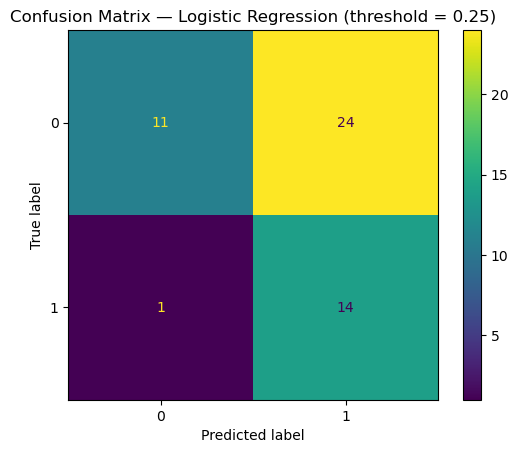

TN=23, FP=12, FN=9, TP=6
Accuracy: 0.5
Precision: 0.3684210526315789
Recall: 0.9333333333333333
F1: 0.509090909090909


In [58]:
#0.25 threshold 
y_proba = logreg.predict_proba(X_test)[:, 1]
y_pred_025 = (y_proba >= 0.25).astype(int)

acc_ = accuracy_score(y_test, y_pred_025)
prec_ = precision_score(y_test, y_pred_025, zero_division=0)
rec_ = recall_score(y_test, y_pred_025, zero_division=0)
f1_ = f1_score(y_test, y_pred_02, zero_division=0)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_025)
plt.title("Confusion Matrix — Logistic Regression (threshold = 0.25)")
plt.show()

print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Accuracy: {acc_}")
print(f"Precision: {prec_}")
print(f"Recall: {rec_}")
print(f"F1: {f1_}")

Accuracy- 50 % orders were correctly predicted

Precision- around 37% "cancelled" orders are flagged correctly

Recall- The model caught around 93% of actual cancellations

F1- Precision/Recall

Using a tuned threshold of 0.25, the model prioritizes recall over precision. This intentionally high recall setting flags more orders, allowing logistics to manage potential cancellations well in advance. 

## Reference 
- Zahid Feroze. “Amazon Sales 2025.” Kaggle.com, 2025, www.kaggle.com/datasets/zahidmughal2343/amazon-sales-2025.